In [ ]:
#This takes a portfolio and determines the optimal weights for each stock in the portfolio based on historical data.

In [5]:
import pandas as pd 
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import yfinance as yf

In [6]:
#list that holds tickers
tickers = ['VXUS', 'VOO', 'SCHB', 'QQQ']
#SPY = most popular S&P 500 Index
#BND = most popular bond index
#GLD = largest comodity based etf
#QQQ = NASDAQ
#VTI = world stock market

In [7]:
end_date = datetime.today()

In [8]:
start_date = end_date - timedelta(days = 5*365)
print("Start date = ", start_date)

Start date =  2020-07-07 01:38:32.640644


In [9]:
#creating an empty dataframe for adjusted close prices
adj_close_df = pd.DataFrame()

In [10]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date, auto_adjust= True)
    adj_close_df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
print(adj_close_df)

                 VXUS         VOO       SCHB         QQQ
Date                                                    
2020-07-07  43.319935  267.584351  11.983038  249.179794
2020-07-08  43.876854  269.571045  12.081129  252.461899
2020-07-09  43.491291  268.197113  12.015199  254.588547
2020-07-10  43.714058  270.889252  12.142235  256.326721
2020-07-13  43.431324  268.438568  12.007158  251.053909
...               ...         ...        ...         ...
2025-06-27  68.910004  565.205017  23.709999  548.090027
2025-06-30  69.089996  568.030029  23.830000  551.640015
2025-07-01  69.110001  567.770020  23.820000  546.989990
2025-07-02  69.330002  570.289978  23.950001  550.799988
2025-07-03  69.489998  575.219971  24.139999  556.219971

[1255 rows x 4 columns]


In [12]:
#lognormal returns for each ticker
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
print(log_returns)

                VXUS       VOO      SCHB       QQQ
Date                                              
2020-07-07       NaN       NaN       NaN       NaN
2020-07-08  0.012774  0.007397  0.008153  0.013086
2020-07-09 -0.008826 -0.005110 -0.005472  0.008388
2020-07-10  0.005109  0.009988  0.010517  0.006804
2020-07-13 -0.006489 -0.009088 -0.011187 -0.020785
...              ...       ...       ...       ...
2025-06-27  0.004072  0.004951  0.005074  0.003418
2025-06-30  0.002609  0.004986  0.005048  0.006456
2025-07-01  0.000289 -0.000458 -0.000420 -0.008465
2025-07-02  0.003178  0.004429  0.005443  0.006941
2025-07-03  0.002305  0.008608  0.007902  0.009792

[1255 rows x 4 columns]


In [13]:
log_returns= log_returns.dropna()
#makes sure that calculations dont get screwed up by any missing information from downloaded info

In [14]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)
#calculating the covariance matrix using annualized log returns

          VXUS       VOO      SCHB       QQQ
VXUS  0.025421  0.022332  0.023165  0.027442
VOO   0.022332  0.029968  0.030602  0.038072
SCHB  0.023165  0.030602  0.031563  0.038959
QQQ   0.027442  0.038072  0.038959  0.054973


In [15]:
#calculating risk from portfolio standard deviation
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights #.T transposes the weights variable @ means multiplying 2 matrices together
    return np.sqrt(variance)

In [16]:
def expected_return(weights, log_returns):
    return np.sum(weights * log_returns.mean()) * 252 #252 trading days in a year


In [17]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [18]:
risk_free_rate = 0.0175 #10 year treasury yield

In [20]:
from fredapi import Fred 
fred = Fred(api_key='8f24635b2a3763bcb7578881a722929c ')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

#set risk free rate to 10 year treasury yield
risk_free_rate = ten_year_treasury_rate.iloc[-1] #latest value
print("Risk free rate = ", risk_free_rate)

Risk free rate =  0.0438


In [21]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [22]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #weights must sum to 1
bounds = [(0, 0.5) for _ in range(len(tickers))] #weights must be between 0 and 0.5

In [23]:
initial_weights = np.array(len(tickers) * [1. / len(tickers)]) #initial guess is equal weights

print(initial_weights)

[0.25 0.25 0.25 0.25]


In [24]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)


In [25]:
optimal_weights = optimized_results.x

In [26]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")
    
print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volitility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected annual return: {optimal_portfolio_return:.2%}")
print(f"Annual volatility: {optimal_portfolio_volitility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.2f}")

Optimal Weights:
VXUS: 0.0000
VOO: 0.5000
SCHB: 0.5000
QQQ: 0.0000

Expected annual return: 14.73%
Annual volatility: 17.52%
Sharpe Ratio: 0.59


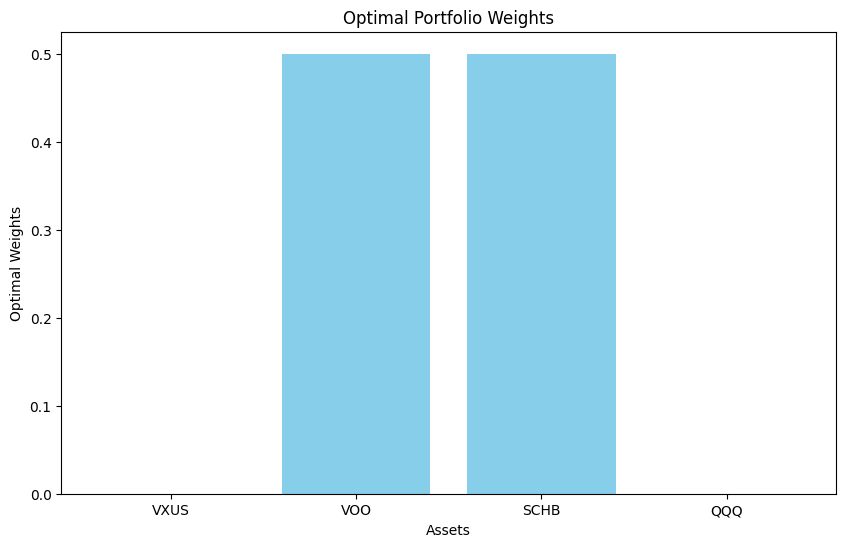

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color='skyblue')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.show()